# Homework 4: Transformer model for language understanding

This tutorial trains a <a href="https://arxiv.org/abs/1706.03762" class="external">Transformer model</a> to translate Portuguese to English. This is an advanced example that assumes knowledge of [text generation](text_generation.ipynb) and [attention](nmt_with_attention.ipynb).

The core idea behind the Transformer model is *self-attention*—the ability to attend to different positions of the input sequence to compute a representation of that sequence. Transformer creates stacks of self-attention layers and is explained below in the sections *Scaled dot product attention* and *Multi-head attention*.

A transformer model handles variable-sized input using stacks of self-attention layers instead of [RNNs](text_classification_rnn.ipynb) or [CNNs](../images/intro_to_cnns.ipynb). This general architecture has a number of advantages:

* It make no assumptions about the temporal/spatial relationships across the data. This is ideal for processing a set of objects (for example, [StarCraft units](https://deepmind.com/blog/alphastar-mastering-real-time-strategy-game-starcraft-ii/#block-8)).
* Layer outputs can be calculated in parallel, instead of a series like an RNN.
* Distant items can affect each other's output without passing through many RNN-steps, or convolution layers (see [Scene Memory Transformer](https://arxiv.org/pdf/1903.03878.pdf) for example).
* It can learn long-range dependencies. This is a challenge in many sequence tasks.

The downsides of this architecture are:

* For a time-series, the output for a time-step is calculated from the *entire history* instead of only the inputs and current hidden-state. This _may_ be less efficient.   
* If the input *does* have a  temporal/spatial relationship, like text, some positional encoding must be added or the model will effectively see a bag of words.

After training the model in this notebook, you will be able to input a Portuguese sentence and return the English translation.

<img src="https://www.tensorflow.org/images/tutorials/transformer/attention_map_portuguese.png" width="800" alt="Attention heatmap">

<font color = 'red'>**IMPORTANT**: The hyperparameters used in the homework are not optimized. Please make sure to tune them to obtain good translations!</font>


<font color='blue'>Just like previous assignments, you will be asked to fill in some lines of codes, and answer a few questions. Please pay attention to contents between #### start code here and ### end codes here. Also, read the comments carefully for hints. </font>

In [269]:
from google.colab import drive
drive.mount('/content/drive')  # 必须在任何文件操作前运行！按提示授权

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [270]:
# 手动创建目录（即使目录存在也安全）
!mkdir -p "/content/drive/MyDrive/checkpoints/train"

# 检查是否创建成功
!ls -l "/content/drive/MyDrive/checkpoints"

total 4
drwx------ 2 root root 4096 Apr  6 10:51 train


In [271]:
# only run this if you have not installed tfds-nightly
!pip install -q tfds-nightly

# Pin matplotlib version to 3.2.2 since in the latest version
# transformer.ipynb fails with the following error:
# https://stackoverflow.com/questions/62953704/valueerror-the-number-of-fixedlocator-locations-5-usually-from-a-call-to-set
# !pip install matplotlib==3.2.2

In [272]:
# run this if you cannot download dataset
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
Paths used for configuration of notebook: 
    	
      - Validating: OK
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json


In [273]:
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy as np
import matplotlib.pyplot as plt

## 0 - Setup input pipeline

Use [TFDS](https://www.tensorflow.org/datasets) to load the [Portugese-English translation dataset](https://github.com/neulab/word-embeddings-for-nmt) from the [TED Talks Open Translation Project](https://www.ted.com/participate/translate).

This dataset contains approximately 50000 training examples, 1100 validation examples, and 2000 test examples. It may take a long of time so please be patient.

In [274]:
tfds.disable_progress_bar()
examples, metadata = tfds.load('ted_hrlr_translate/pt_to_en', with_info=True,
                               as_supervised=True) # you may encounter errors running this line, make sure you install the right version of tensorflow, tfds, and enable extentsions above
train_examples, val_examples = examples['train'], examples['validation']

Create a custom subwords tokenizer from the training dataset.

In [275]:
tokenizer_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (en.numpy() for pt, en in train_examples), target_vocab_size=2**13)

tokenizer_pt = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    (pt.numpy() for pt, en in train_examples), target_vocab_size=2**13)

In [276]:
sample_string = 'Transformer is awesome.'

tokenized_string = tokenizer_en.encode(sample_string)
print ('Tokenized string is {}'.format(tokenized_string))

original_string = tokenizer_en.decode(tokenized_string)
print ('The original string: {}'.format(original_string))

assert original_string == sample_string

Tokenized string is [7915, 1248, 7946, 7194, 13, 2799, 7877]
The original string: Transformer is awesome.


The tokenizer encodes the string by breaking it into subwords if the word is not in its dictionary.

In [277]:
for ts in tokenized_string:
  print ('{} ----> {}'.format(ts, tokenizer_en.decode([ts])))

7915 ----> T
1248 ----> ran
7946 ----> s
7194 ----> former 
13 ----> is 
2799 ----> awesome
7877 ----> .


In [278]:
BUFFER_SIZE = 20000
BATCH_SIZE = 32

Add a start and end token to the input and target.

In [279]:
def encode(lang1, lang2):
  lang1 = [tokenizer_pt.vocab_size] + tokenizer_pt.encode(
      lang1.numpy()) + [tokenizer_pt.vocab_size+1]

  lang2 = [tokenizer_en.vocab_size] + tokenizer_en.encode(
      lang2.numpy()) + [tokenizer_en.vocab_size+1]

  return lang1, lang2

You want to use `Dataset.map` to apply this function to each element of the dataset.  `Dataset.map` runs in graph mode.

* Graph tensors do not have a value.
* In graph mode you can only use TensorFlow Ops and functions.

So you can't `.map` this function directly: You need to wrap it in a `tf.py_function`. The `tf.py_function` will pass regular tensors (with a value and a `.numpy()` method to access it), to the wrapped python function.

In [280]:
def tf_encode(pt, en):
  result_pt, result_en = tf.py_function(encode, [pt, en], [tf.int64, tf.int64])
  result_pt.set_shape([None])
  result_en.set_shape([None])

  return result_pt, result_en

Note: To keep this example small and relatively fast, drop examples with a length of over 25 tokens.

In [281]:
MAX_LENGTH = 25

In [282]:
def filter_max_length(x, y, max_length=MAX_LENGTH):
  return tf.logical_and(tf.size(x) <= max_length,
                        tf.size(y) <= max_length)

In [283]:
train_dataset = train_examples.map(tf_encode)
train_dataset = train_dataset.filter(filter_max_length)
# cache the dataset to memory to get a speedup while reading from it.
train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)


val_dataset = val_examples.map(tf_encode)
val_dataset = val_dataset.filter(filter_max_length).padded_batch(BATCH_SIZE)

In [284]:
pt_batch, en_batch = next(iter(val_dataset))
pt_batch, en_batch

(<tf.Tensor: shape=(32, 23), dtype=int64, numpy=
 array([[8214,  342, 3032,   15, 5917,   20, 4347, 1189,   17, 1784, 1412,
           29, 8215,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [8214,   95,  198, 6850, 7990,   14,   44, 6732,    7,    6, 2211,
           15,    4,  555,    2, 8215,    0,    0,    0,    0,    0,    0,
            0],
        [8214, 4479, 7990,    9,   20,    7, 5611,    4, 4416,    4,   10,
         4622, 2878,   20,    9, 1348, 2682,   97,    2, 8215,    0,    0,
            0],
        [8214,   25,   27,  278,    5,   42,    8, 3850, 3308, 8069,    2,
         8215,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0],
        [8214,   62, 1181,   15,    7,  122, 3173, 7990,   33, 3264, 2745,
         5868,  585,    2, 8215,    0,    0,    0,    0,    0,    0,    0,
            0],
        [8214, 8059,    1,   24,   69, 7276,    1,    8,   10, 6346,   13,
          105,   11,  297,    1,   25,   11,  

<a name='1'></a>
## 1 - Positional Encoding

In sequence to sequence tasks, the relative order of your data is extremely important to its meaning. When you were training sequential neural networks such as RNNs, you fed your inputs into the network in order. Information about the order of your data was automatically fed into your model.  However, when you train a Transformer network, you feed your data into the model all at once. While this dramatically reduces training time, there is no information about the order of your data. This is where positional encoding is useful - you can specifically encode the positions of your inputs and pass them into the network using these sine and cosine formulas:
    
$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{1}$$
<br>
$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
\tag{2}$$

* $d$ is the dimension of the word embedding and positional encoding
* $pos$ is the position of the word.
* $i$ refers to each of the different dimensions of the positional encoding.

The values of the sine and cosine equations are small enough (between -1 and 1) that when you add the positional encoding to a word embedding, the word embedding is not significantly distorted. The sum of the positional encoding and word embeding is ultimately what is fed into the model. Using a combination of these two equations helps your Transformer network attend to the relative positions of your input data. Note that in this assignment, all vectors are horizontal. All matrix multiplications should be adjusted accordingly.

<a name='1-1'></a>
### 1.1 - Sine and Cosine Angles

Get the possible angles used to compute the positional encodings by calculating the inner term of the sine and cosine equations:

$$\frac{pos}{10000^{\frac{2i}{d}}} \tag{3}$$

<a name='ex-1'></a>
### Exercise 1 - get_angles

Implement the function `get_angles()` to calculate the possible angles for the sine and cosine  positional encodings

In [285]:
def get_angles(pos, i, dim):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(dim))
  return pos * angle_rates

<a name='1-2'></a>
### 1.2 - Sine and Cosine Positional Encodings

Now you can use the angles you computed to calculate the sine and cosine positional encodings.

$$
PE_{(pos, 2i)}= sin\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
$$
<br>
$$
PE_{(pos, 2i+1)}= cos\left(\frac{pos}{{10000}^{\frac{2i}{d}}}\right)
$$


<a name='ex-2'></a>
### Exercise 2 - positional_encoding

Implement the function `positional_encoding()` to calculate the sine and cosine  positional encodings

**Reminder:** Use the sine equation when $i$ is an even number and the cosine equation when $i$ is an odd number.

#### Additional Hints
* You may find
[np.newaxis](https://numpy.org/doc/stable/reference/arrays.indexing.html) useful depending on the implementation you choose.

In [286]:
def positional_encoding(position, dim):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(dim)[np.newaxis, :],
                          dim)
  # START CODE HERE

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
  # END CODE HERE

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 200, 512)


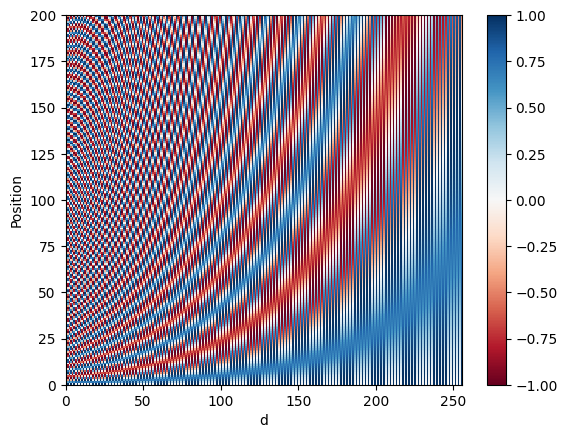

In [287]:
pos_encoding = positional_encoding(200, 512)

print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d')
plt.xlim((0, 256))
plt.ylabel('Position')
plt.colorbar()
plt.show()

<a name='2'></a>
## 2 - Masking

There are two types of masks that are useful when building your Transformer network: the *padding mask* and the *look-ahead mask*. Both help the softmax computation give the appropriate weights to the words in your input sentence.

<a name='2-1'></a>
### 2.1 - Padding Mask

Oftentimes your input sequence will exceed the maximum length of a sequence your network can process. Let's say the maximum length of your model is five, it is fed the following sequences:

    [["Do", "you", "know", "when", "Jane", "is", "going", "to", "visit", "Africa"],
     ["Jane", "visits", "Africa", "in", "September" ],
     ["Exciting", "!"]
    ]

which might get vectorized as:

    [[ 71, 121, 4, 56, 99, 2344, 345, 1284, 15],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600]
    ]
    
When passing sequences into a transformer model, it is important that they are of uniform length. You can achieve this by padding the sequence with zeros, and truncating sentences that exceed the maximum length of your model:

    [[ 71, 121, 4, 56, 99],
     [ 2344, 345, 1284, 15, 0],
     [ 56, 1285, 15, 181, 545],
     [ 87, 600, 0, 0, 0],
    ]
    
Sequences longer than the maximum length of five will be truncated, and zeros will be added to the truncated sequence to achieve uniform length. Similarly, for sequences shorter than the maximum length, they zeros will also be added for padding. However, these zeros will affect the softmax calculation - this is when a padding mask comes in handy! By multiplying a padding mask by -1e9 and adding it to your sequence, you mask out the zeros by setting them to close to negative infinity. We'll implement this for you so you can get to the fun of building the Transformer network! 😇 Just make sure you go through the code so you can correctly implement padding when building your model.

After masking, your input should go from `[87, 600, 0, 0, 0]` to `[87, 600, -1e9, -1e9, -1e9]`, so that when you take the softmax, the zeros don't affect the score.

<font color='blue'> **Important！** In class we talked about two way to implement masking: 1) forcing post-Softmax attention score to be 0, in this case, you need to set positions you *do not* want attentions to be 0; 2) forcing pre-Softmax attention score to be large negative values (so that after Softmax they become zero), in this case, your mask is actually the inverse of the previous one, as you need to set values corresponding to those unattended postions to be 1. Here we used the 2nd scheme while Tensorflow default method MultiHeadAttention uses the 1st one. </font>

In [288]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len) notice that we add two new dimension here in order to broad cast to the multi-head dimension and query dimenion

In [289]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

<a name='2-2'></a>
### 2.2 - Look-ahead Mask

The look-ahead mask follows similar intuition. In training, you will have access to the complete correct output of your training example. The look-ahead mask helps your model pretend that it correctly predicted a part of the output and see if, *without looking ahead*, it can correctly predict the next output.

For example, if the expected correct output is `[1, 2, 3]` and you wanted to see if given that the model correctly predicted the first value it could predict the second value, you would mask out the second and third values. So you would input the masked sequence `[1, -1e9, -1e9]` and see if it could generate `[1, 2, -1e9]`.

To implement look-ahead mask, we will use the [band_part](https://www.tensorflow.org/api_docs/python/tf/linalg/band_part) function in the tf.linalg library.

In [290]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [291]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

## 3 - Self-Attention

### 3.1 - Single-Head Attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/scaled_attention.png" width="500" alt="scaled_dot_product_attention">

<a name='3'></a>


As the authors of the Transformers paper state, "Attention is All You Need".

<img src="self-attention.png" alt="Encoder" width="600"/>
<caption><center><font color='purple'><b>Figure 1: Self-Attention calculation visualization</font></center></caption>
    
The use of self-attention paired with traditional convolutional networks allows for the parallization which speeds up training. You will implement **scaled dot product attention** which takes in a query, key, value, and a mask as inputs to returns rich, attention-based vector representations of the words in your sequence. This type of self-attention can be mathematically expressed as:
$$
\text { Attention }(Q, K, V)=\operatorname{softmax}\left(\frac{Q K^{T}}{\sqrt{d_{k}}}+{M}\right) V\tag{4}\
$$

* $Q$ is the matrix of queries
* $K$ is the matrix of keys
* $V$ is the matrix of values
* $M$ is the optional mask you choose to apply
* ${d_k}$ is the dimension of the keys, which is used to scale everything down so the softmax doesn't explode, notice that scaling a vector by a constant does not change the eventual softmax values.

<font color='blue'> Notice that the vectors here are represented a **row** vectors, instead of column vectors. The Q, K, and V matrices are all transpose of those appeared in course slides. </font>

<a name='ex-3'></a>
### Exercise 3 - scaled_dot_product_attention

Implement the function `scaled_dot_product_attention()` to create attention-based representations.
    
**Important notes**:  Here we implemented a more general version of attention where the query sequence may be different from the target squence. Hence the length of query sequence may not be the same as the length of the target. However, if we use this function for self-attention, where the query and target are the same sequence (hence the term "self" in its name), then the length of query sequence shall match the length of the target.
    
**Reminder**: The mask is multiplied with -1e9 (close to negative infinity). This is done because the mask is summed with the scaled matrix multiplication of Q and K and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

**Additional Hints**
* You may find [tf.matmul](https://www.tensorflow.org/api_docs/python/tf/linalg/matmul) useful for matrix multiplication.

In [292]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  # START CODE HERE: Use tf.matmul to obtain unnomralized attention weights, remember to transpose K
  matmul_qk = tf.matmul(q, k, transpose_b=True)   # (..., seq_len_q, seq_len_k)
  # END CODE HERE


  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.

  # START CODE HERE: add (mask * -1e9)  to attention_logits
  if mask is not None:
    scaled_attention_logits += (tf.cast(mask, tf.float32) * -1e9)
  # END CODE HERE

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [293]:
def scaled_dot_product_attention_test(target):
    q = np.array([[1, 0, 1, 1], [0, 1, 1, 1], [1, 0, 0, 1]]).astype(np.float32)
    k = np.array([[1, 1, 0, 1], [1, 0, 1, 1 ], [0, 1, 1, 0], [0, 0, 0, 1]]).astype(np.float32)
    v = np.array([[0, 0], [1, 0], [1, 0], [1, 1]]).astype(np.float32)

    attention, weights = target(q, k, v, None)
    assert tf.is_tensor(weights), "Weights must be a tensor"
    assert tuple(tf.shape(weights).numpy()) == (q.shape[0], k.shape[1]), f"Wrong shape. We expected ({q.shape[0]}, {k.shape[1]})"
    assert np.allclose(weights, [[0.2589478,  0.42693272, 0.15705977, 0.15705977],
                                   [0.2772748,  0.2772748,  0.2772748,  0.16817567],
                                   [0.33620113, 0.33620113, 0.12368149, 0.2039163 ]])

    assert tf.is_tensor(attention), "Output must be a tensor"
    assert tuple(tf.shape(attention).numpy()) == (q.shape[0], v.shape[1]), f"Wrong shape. We expected ({q.shape[0]}, {v.shape[1]})"
    assert np.allclose(attention, [[0.74105227, 0.15705977],
                                   [0.7227253,  0.16817567],
                                   [0.6637989,  0.2039163 ]])

    mask = np.array([[0, 0, 1, 0], [0, 0, 1, 0], [0, 0, 1, 0]])
    attention, weights = target(q, k, v, mask)

    assert np.allclose(weights, [[0.30719590187072754, 0.5064803957939148, 0.0, 0.18632373213768005],
                                 [0.3836517333984375, 0.3836517333984375, 0.0, 0.2326965481042862],
                                 [0.3836517333984375, 0.3836517333984375, 0.0, 0.2326965481042862]]), "Wrong masked weights"
    assert np.allclose(attention, [[0.6928040981292725, 0.18632373213768005],
                                   [0.6163482666015625, 0.2326965481042862],
                                   [0.6163482666015625, 0.2326965481042862]]), "Wrong masked attention"

    print("\033[92mAll tests passed!")

scaled_dot_product_attention_test(scaled_dot_product_attention)

All tests passed!


As the softmax normalization is done on K, its values decide the amount of importance given to Q.

The output represents the multiplication of the attention weights and the V (value) vector. This ensures that the words you want to focus on are kept as-is and the irrelevant words are flushed out.

In [294]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [295]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [296]:
# This query aligns with a repeated key (third and fourth),
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [297]:
# This query aligns equally with the first and second key,
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


Pass all the queries together.

In [298]:
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v)

Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


### 3.2 - Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
*    Linear layers and split into heads.
*    Scaled dot-product attention.
*    Concatenation of heads.
*    Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads.

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.


<img src="hydra.jpg" alt="Encoder" width="250"/>
<caption><center><font color='purple'><b>Figure 2: A live demo of Multi-Head Attention</font></center></caption>

In [299]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, hidden):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads   # number of heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0   # d_model == length of key/query * num_heads

    self.depth = d_model // self.num_heads # the depth is the length of the key and queries

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    # for simplicity, here the depth of v vector is set to be the same of depth of k and q, you can relax this constrait. The cost is one extra argument to pass
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(hidden)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)

    # START CODE HERE
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    # END CODE HERE

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)

    # START CODE HERE: USE scaled_dot_product_attention FUNCTION TO OBTAIN ATTENTIONS AND ATTENTION WEIGHTS, DO NOT FORGET TO PASS MASK AS AN ARGUMENT
    scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
    # END CODE HERE

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model), here we concatenate the attention_weighted output from multiple attentions

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, hidden)

    return output, attention_weights

Create a `MultiHeadAttention` layer to try out. At each location in the sequence, `y`, the `MultiHeadAttention` runs all 8 attention heads across all other locations in the sequence, returning a new vector of the same length at each location.

In [300]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8, hidden = 300)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, input length)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 300]), TensorShape([1, 8, 60, 60]))

### 3.3 - Point wise feed forward network

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [301]:
def point_wise_feed_forward_network(hidden, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(hidden)  # (batch_size, seq_len, hidden)
  ])

In [302]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

## 4 - Encoder and decoder

<img src="https://www.tensorflow.org/images/tutorials/transformer/transformer.png" width="600" alt="transformer">

The transformer model follows the same general pattern as a standard [sequence to sequence with attention model](nmt_with_attention.ipynb).

* The input sentence is passed through `N` encoder layers that generates an output for each word/token in the sequence.
* The decoder attends on the encoder's output and its own input (self-attention) to predict the next word.

### 4.1 - Encoder layer


The Transformer Encoder layer pairs self-attention and convolutional neural network style of processing to improve the speed of training and passes K and V matrices to the Decoder, which you'll build later in the assignment. In this section of the assignment, you will implement the Encoder by pairing multi-head attention and a feed forward neural network (Figure 2a).
<img src="encoder_layer.png" alt="Encoder" width="250"/>
<caption><center><font color='purple'><b>Figure 3a: Transformer encoder layer</font></center></caption>

* Both `MultiHeadAttention` and `FeedForward` layers have been defined previously, as in session 3.

    
Your input sentence first passes through a *multi-head attention layer*, where the encoder looks at other words in the input sentence as it encodes a specific word. The outputs of the multi-head attention layer are then fed to a *feed forward neural network*. The exact same feed forward network is independently applied to each position.

The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis. There are N encoder layers in the transformer.

In [303]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, hidden, rate=0.1):
    super().__init__()

    self.mha = MultiHeadAttention(d_model, num_heads, hidden)
    self.ffn = point_wise_feed_forward_network(hidden, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    # START CODE HERE
    attn_output, _ = self.mha(x, k=x, q=x, mask=mask)   # INPUT x,x, AND x, OUTPUT SHAPE (batch_size, input_seq_len, hidden)
    # END CODE HERE
    attn_output = self.dropout1(attn_output, training=training)  # the dropout layer behaves differently during training or inference stage ,hence you need to pass teh training argument
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, hidden), this is the residual unit, or skip connection unit

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    # START CODE HERE: ADD DROPOUT, RESIDUAL UNIT AND LAYERNORM2
    ffn_output = self.dropout2(ffn_output, training=training)

    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    # END CODE HERE
    return out2

In [304]:
sample_encoder_layer = EncoderLayer(512, 8, 2048, 300)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 300)), training=False, mask=None) # input dimension has to be the same as hidden dimension

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, hidden)

TensorShape([64, 43, 300])

### 4.2 - Decoder layer

The Decoder layer takes the K and V matrices generated by the Encoder and in computes the second multi-head attention layer with the Q matrix from the output (Figure 3a).

<img src="decoder_layer.png" alt="Encoder" width="250"/>
<caption><center><font color='purple'><b>Figure 3b: Transformer Decoder layer</font></center></caption>



Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). V (value) and K (key) receive the *encoder output* as inputs. Q (query) receives the *output from the masked multi-head attention sublayer.*
3.   Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [305]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, hidden, rate=0.1):
    super().__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads, hidden)
    self.mha2 = MultiHeadAttention(d_model, num_heads, hidden)

    self.ffn = point_wise_feed_forward_network(hidden, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)


  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, hidden)
    # START CODE HERE: ATTENTION, DROPOUT, RESIDUAL AND LAYERNORM1
    attn1, attn_weights_block1 = self.mha1(x, k=x, q=x, mask=look_ahead_mask)  # (batch_size, target_seq_len, hidden)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(x + attn1)
    # END CODE EHRE


    # START CODE HERE: ATTENTION, DROPOUT, RESIDUAL AND LAYERNORM1
    attn2, attn_weights_block2 = self.mha2(enc_output, k=enc_output, q=out1, mask=padding_mask)   #  v, k, q, output is of shape (batch_size, target_seq_len, hidden)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(out1 + attn2)  # (batch_size, target_seq_len, hidden)
    # END CODE HERE

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, hidden)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, hidden)

    return out3, attn_weights_block1, attn_weights_block2

In [306]:
sample_decoder_layer = DecoderLayer(512, 8, 2048, 300)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 300)), sample_encoder_layer_output,
    training = False, look_ahead_mask = None, padding_mask = None) # decoder input dim == hidden dimension, you can change the residual unit yourself if you do not like this constraint

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, hidden)

TensorShape([64, 50, 300])

### 4.3 - Full Encoder

The `Encoder` consists of:
1.   Input Embedding
2.   Positional Encoding
3.   N encoder layers, will be passed as the `num_layers` argument

The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [307]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, hidden,input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super().__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.hidden = hidden

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, hidden)
    self.pos_encoding = positional_encoding(maximum_position_encoding,
                                            hidden)

    # START CODE HERE: ADD num_layers Encoderlayer, put in a list,
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, hidden, rate)
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, hidden)
    x *= tf.math.sqrt(tf.cast(self.hidden, tf.float32))  # this line is to normalize the variance of embeddings so it does not explode
    x += self.pos_encoding[:, :seq_len, :]
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training = training, mask = mask ) #进行了一些小修改，加入关键字参数进行传递

    return x  # (batch_size, input_seq_len, hidden)

In [308]:
sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
                         dff=1024, hidden = 300,input_vocab_size=8500,
                         maximum_position_encoding=10000)
temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)
print(temp_input)

sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

tf.Tensor(
[[149 154  36 ... 119 101 139]
 [ 30  76 186 ... 128 126 149]
 [141 126 135 ... 189  75  95]
 ...
 [121 174   9 ...  27  22 178]
 [174 136  51 ... 178 152  40]
 [130  44  68 ... 110  46 112]], shape=(64, 62), dtype=int64)
(64, 62, 300)


### 4.4 - Full Decoder
 The `Decoder` consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [309]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, hidden,target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.hidden = hidden

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, hidden)
    self.pos_encoding = positional_encoding(maximum_position_encoding, hidden)

    # START CODE HERE: ADD num_layers OF DecoderLayer

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, hidden, rate)   # add code here
                       for _ in range(num_layers)]
    # END CODE HERE
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask=None, padding_mask =None):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, hidden)
    x *= tf.math.sqrt(tf.cast(self.hidden, tf.float32))

    # START CODE HERE: ADD POS_ENCODING, FOLLOWED BY A DROPOUT LAYER
    x += self.pos_encoding[:, :seq_len, :]    # postional encoding
    x = self.dropout(x, training=training)     # dropout
    # END CODE HERE

    for i in range(self.num_layers):
      # START CODE HERE
      x, block1, block2 = self.dec_layers[i](x, enc_output, training=training, look_ahead_mask=look_ahead_mask, padding_mask=padding_mask)
      # END CODE HERE

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [310]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, hidden = 300,
                         dff=1024, target_vocab_size=8000,
                         maximum_position_encoding=5000)
temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=False,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 300]), TensorShape([64, 8, 26, 62]))

<a name='6'></a>
## 6 - Transformer

We are close! Now let's build a transformer.

<img src="transformer.png" alt="Transformer" width="550"/>
<caption><center><font color='purple'><b>Figure 4: Transformer</font></center></caption>
    
The flow of data through the Transformer Architecture is as follows:
* First your input passes through an Encoder, which is just repeated Encoder layers that you implemented:
    - embedding and positional encoding of your input
    - multi-head attention on your input
    - feed forward neural network to help detect features
* Then the predicted output passes through a Decoder, consisting of the decoder layers that you implemented:
    - embedding and positional encoding of the output
    - multi-head attention on your generated output
    - multi-head attention with the Q from the first multi-head attention layer and the K and V from the Encoder
    - a feed forward neural network to help detect features
* Finally, after the Nth Decoder layer, one dense layers and a softmax are applied to generate prediction for the next output in your sequence.


In [311]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, hidden,input_vocab_size,
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, hidden,
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff,hidden,
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training=False, enc_padding_mask=None, look_ahead_mask=None, dec_padding_mask=None):

    enc_output = self.encoder(inp, training = training, mask = enc_padding_mask)  # (batch_size, inp_seq_len, hidden)

    # dec_output.shape == (batch_size, tar_seq_len, hidden)
    # START CODE HERE
    dec_output, attention_weights = self.decoder( tar, enc_output, training = training, look_ahead_mask = look_ahead_mask, padding_mask = dec_padding_mask    # ADD ARUMENTS TO THIS LINE
        )
    # END CODE HERE

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

In [312]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=1024, hidden = 300,
    input_vocab_size=8500, target_vocab_size=8000,
    pe_input=10000, pe_target=6000)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer(temp_input, temp_target, training=False,
                               enc_padding_mask=None,
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 36, 8000])

## Set hyperparameters

To keep this example small and relatively fast, the values for *num_layers, d_model, and dff* have been reduced.

The values used in the base model of transformer were; *num_layers=6*, *d_model = 512*, *dff = 2048*. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

Note: By changing the values below, you can get the model that achieved state of the art on many tasks.

In [313]:
num_layers = 4

d_model = 128
# dff = 512 跑起来太慢了，改小一点
dff = 256
num_heads = 8
hidden = 300

input_vocab_size = tokenizer_pt.vocab_size + 2
target_vocab_size = tokenizer_en.vocab_size + 2
dropout_rate = 0.1

## Optimizer

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$


In [314]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32) # 数据类型规定为float
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [315]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

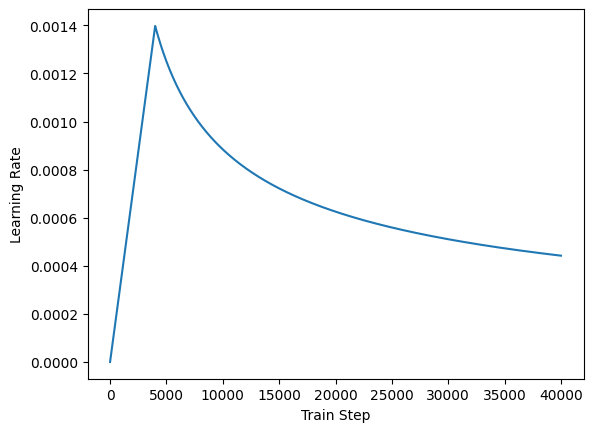

In [316]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Loss and metrics

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [317]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [318]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0)) # token 0 stands for padded token, will not consider it into the loss fuction
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype) # make sure the same dtype
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask) # this is modified reduce_mean, excluding padded 0 in the true labels.

In [319]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

## Training and checkpointing

In [320]:
transformer = Transformer(num_layers, d_model, num_heads, dff,hidden,
                          input_vocab_size, target_vocab_size,
                          pe_input=input_vocab_size,
                          pe_target=target_vocab_size,
                          rate=dropout_rate)

In [321]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs. That is why it is created using input seq!
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by
  # the decoder.

  # START CODE HERE: pass tar.shape[1] to creat look-ahead mask. pass tar to creat padding mask, use functions defined in Session 2
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  # END CODE HERE

  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask) # we will pass combined mask in place of look ahead mask, why?
#   combined_mask = None
  return enc_padding_mask, combined_mask, dec_padding_mask

Create the checkpoint path and the checkpoint manager. This will be used to save checkpoints every `n` epochs.

In [329]:
# 检查点路径指向 Google Drive
checkpoint_path = "/content/drive/MyDrive/checkpoints/train"
ckpt = tf.train.Checkpoint(transformer=transformer, optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [330]:
# 恢复检查点（必须在模型和优化器初始化之后）
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(f"已恢复检查点: {ckpt_manager.latest_checkpoint}")

已恢复检查点: /content/drive/MyDrive/checkpoints/train/ckpt-9


In [331]:
class TrainingState:
    def __init__(self):
        self.epoch = tf.Variable(0, dtype=tf.int64, name='epoch')
        self.batch = tf.Variable(0, dtype=tf.int64, name='batch')

In [332]:
BUFFER_SIZE = 20000
BATCH_SIZE = 256

The target is divided into tar_inp and tar_real. tar_inp is passed as an input to the decoder. `tar_real` is that same input shifted by 1: At each location in `tar_input`, `tar_real` contains the  next token that should be predicted.

For example, `sentence` = "SOS A lion in the jungle is sleeping EOS"

`tar_inp` =  "SOS A lion in the jungle is sleeping"

`tar_real` = "A lion in the jungle is sleeping EOS"

The transformer is an auto-regressive model: it makes predictions one part at a time, and uses its output so far to decide what to do next.

During training this example uses teacher-forcing (like in the [text generation tutorial](./text_generation.ipynb)). Teacher forcing is passing the true output to the next time step regardless of what the model predicts at the current time step.

As the transformer predicts each word, *self-attention* allows it to look at the previous words in the input sequence to better predict the next word.

To prevent the model from peeking at the expected output the model uses a look-ahead mask.

In [333]:
EPOCHS = 2 # you can modify this hyperparameter

In [335]:
# 绑定检查点对象（包含所有需要恢复的变量）
checkpoint_path = "/content/drive/MyDrive/checkpoints/train"
ckpt = tf.train.Checkpoint(
    transformer=transformer,
    optimizer=optimizer,
    epoch=tf.Variable(0, dtype=tf.int64),  # 全局epoch计数器
    batch=tf.Variable(0, dtype=tf.int64)   # 全局batch计数器
)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
# 恢复最新检查点（优先执行）
state = TrainingState()
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(f"✅ 成功恢复检查点: {ckpt_manager.latest_checkpoint}")
    print(f"📅 当前进度: Epoch {state.epoch.numpy()}, Batch {state.batch.numpy()}")
else:
    print("❌ 无检查点，从头开始训练")

✅ 成功恢复检查点: /content/drive/MyDrive/checkpoints/train/ckpt-9
📅 当前进度: Epoch 0, Batch 0


In [336]:
# 打印检查点中的变量值
print("检查点中的 epoch:", ckpt.epoch.numpy())
print("检查点中的 batch:", ckpt.batch.numpy())
print("优化器迭代次数:", optimizer.iterations.numpy())

检查点中的 epoch: 0
检查点中的 batch: 0
优化器迭代次数: 1783


Portuguese is used as the input language and English is the target language.

In [337]:
for epoch in range(EPOCHS):
  start = time.time()

  # train_loss.reset_states()
  # train_accuracy.reset_states()
  train_loss.reset_state() # 修改了一下，TensorFlow的新版本对这一方法的名称进行了更新
  train_accuracy.reset_state()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)
    with tf.GradientTape() as tape:
      predictions, _ = transformer(inp, tar_inp,
                                 training = True,
                                 enc_padding_mask = enc_padding_mask,
                                 look_ahead_mask = combined_mask,
                                 dec_padding_mask = dec_padding_mask)
      loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(tar_real, predictions)

    # 更新全局 batch 计数器
    state.batch.assign_add(1)

    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))

  # 更新全局 epoch 计数器并重置 batch
  state.epoch.assign_add(1)
  state.batch.assign(0)

  # 每个 epoch 结束时保存检查点（更安全）
  ckpt_save_path = ckpt_manager.save()
  print(f'Epoch {epoch+1} Loss: {train_loss.result():.4f} Accuracy: {train_accuracy.result():.4f}')
  print(f'Time: {time.time()-start:.2f} secs, Checkpoint: {ckpt_save_path}\n')


#   break

Epoch 1 Batch 0 Loss 4.9758 Accuracy 0.1590
Epoch 1 Batch 50 Loss 4.7801 Accuracy 0.1719
Epoch 1 Batch 100 Loss 4.7693 Accuracy 0.1701
Epoch 1 Batch 150 Loss 4.7553 Accuracy 0.1708
Epoch 1 Batch 200 Loss 4.7407 Accuracy 0.1720
Epoch 1 Batch 250 Loss 4.7296 Accuracy 0.1722
Epoch 1 Batch 300 Loss 4.7118 Accuracy 0.1734
Epoch 1 Batch 350 Loss 4.6999 Accuracy 0.1742
Epoch 1 Batch 400 Loss 4.6809 Accuracy 0.1756
Epoch 1 Batch 450 Loss 4.6642 Accuracy 0.1766
Epoch 1 Batch 500 Loss 4.6519 Accuracy 0.1775
Epoch 1 Batch 550 Loss 4.6391 Accuracy 0.1783
Epoch 1 Batch 600 Loss 4.6282 Accuracy 0.1791
Epoch 1 Batch 650 Loss 4.6151 Accuracy 0.1795
Epoch 1 Batch 700 Loss 4.6030 Accuracy 0.1803
Epoch 1 Batch 750 Loss 4.5946 Accuracy 0.1807
Epoch 1 Batch 800 Loss 4.5886 Accuracy 0.1815
Epoch 1 Batch 850 Loss 4.5799 Accuracy 0.1819
Epoch 1 Batch 900 Loss 4.5702 Accuracy 0.1826
Epoch 1 Batch 950 Loss 4.5625 Accuracy 0.1831
Epoch 1 Batch 1000 Loss 4.5525 Accuracy 0.1838
Epoch 1 Batch 1050 Loss 4.5477 Accur

In [338]:
# 手动保存一次检查点（验证写入权限）
save_path = ckpt_manager.save()
print("检查点已保存至:", save_path)

检查点已保存至: /content/drive/MyDrive/checkpoints/train/ckpt-12


## Evaluate

The following steps are used for evaluation:

* Encode the input sentence using the Portuguese tokenizer (`tokenizer_pt`). Moreover, add the start and end token so the input is equivalent to what the model is trained with. This is the encoder input.
* The decoder input is the `start token == tokenizer_en.vocab_size`.
* Calculate the padding masks and the look ahead masks.
* The `decoder` then outputs the predictions by looking at the `encoder output` and its own output (self-attention).
* Select the last word and calculate the argmax of that.
* Concatentate the predicted word to the decoder input as pass it to the decoder.
* In this approach, the decoder predicts the next word based on the previous words it predicted.

Note: The model used here has less capacity to keep the example relatively faster so the predictions maybe less right. To reproduce the results in the paper, use the entire dataset and base transformer model or transformer XL, by changing the hyperparameters above.

In [339]:
def evaluate(inp_sentence):
  start_token = [tokenizer_pt.vocab_size]
  end_token = [tokenizer_pt.vocab_size + 1]

  # inp sentence is portuguese, hence adding the start and end token
  inp_sentence = start_token + tokenizer_pt.encode(inp_sentence) + end_token
  encoder_input = tf.expand_dims(inp_sentence, 0)

  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [tokenizer_en.vocab_size]
  output = tf.expand_dims(decoder_input, 0)

  for i in range(MAX_LENGTH):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(inp =  encoder_input,
                            tar = output,
                            training = False,
                            enc_padding_mask = enc_padding_mask,
                            look_ahead_mask = combined_mask,
                            dec_padding_mask = dec_padding_mask
                            )

    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if predicted_id == tokenizer_en.vocab_size+1:
      return tf.squeeze(output, axis=0), attention_weights

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [340]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(16, 8))

  sentence = tokenizer_pt.encode(sentence)

  attention = tf.squeeze(attention[layer], axis=0)

  for head in range(attention.shape[0]):
    ax = fig.add_subplot(2, 4, head+1)

    # plot the attention weights
    ax.matshow(attention[head][:-1, :], cmap='viridis')


    fontdict = {'fontsize': 10}

    ax.set_xticks(range(len(sentence)+2))
    ax.set_yticks(range(len(result)-1))

    ax.set_ylim(len(result)-1.5, -0.5)

    ax.set_xticklabels(
        ['<start>']+[tokenizer_pt.decode([i]) for i in sentence]+['<end>'],
        fontdict=fontdict, rotation=90)

    ax.set_yticklabels([tokenizer_en.decode([i]) for i in result
                        if i < tokenizer_en.vocab_size],
                       fontdict=fontdict)

    ax.set_xlabel('Head {}'.format(head+1))

  plt.tight_layout()
  plt.show()

In [341]:
def translate(sentence, plot=''):
  result, attention_weights = evaluate(sentence)

  predicted_sentence = tokenizer_en.decode([i for i in result
                                            if i < tokenizer_en.vocab_size])

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))

  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [342]:
translate("este é um problema que temos que resolver.")
print ("Real translation: this is a problem we have to solve .")

Input: este é um problema que temos que resolver.
Predicted translation: this is a little bit of that we can do this is a little bit of the world we know .
Real translation: this is a problem we have to solve .


In [343]:
translate("os meus vizinhos ouviram sobre esta ideia.")
print ("Real translation: and my neighboring homes heard about this idea .")

Input: os meus vizinhos ouviram sobre esta ideia.
Predicted translation: so i was going to give you a couple of the first of the first of the time .
Real translation: and my neighboring homes heard about this idea .


In [344]:
translate("vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.")
print ("Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .")

Input: vou então muito rapidamente partilhar convosco algumas histórias de algumas coisas mágicas que aconteceram.
Predicted translation: so i want to show you what i want to do with this little like this .
Real translation: so i 'll just share with you some stories very quickly of some magical things that have happened .


You can pass different layers and attention blocks of the decoder to the `plot` parameter.

Input: este é o primeiro livro que eu fiz.
Predicted translation: this is the first thing we call this for this moment .


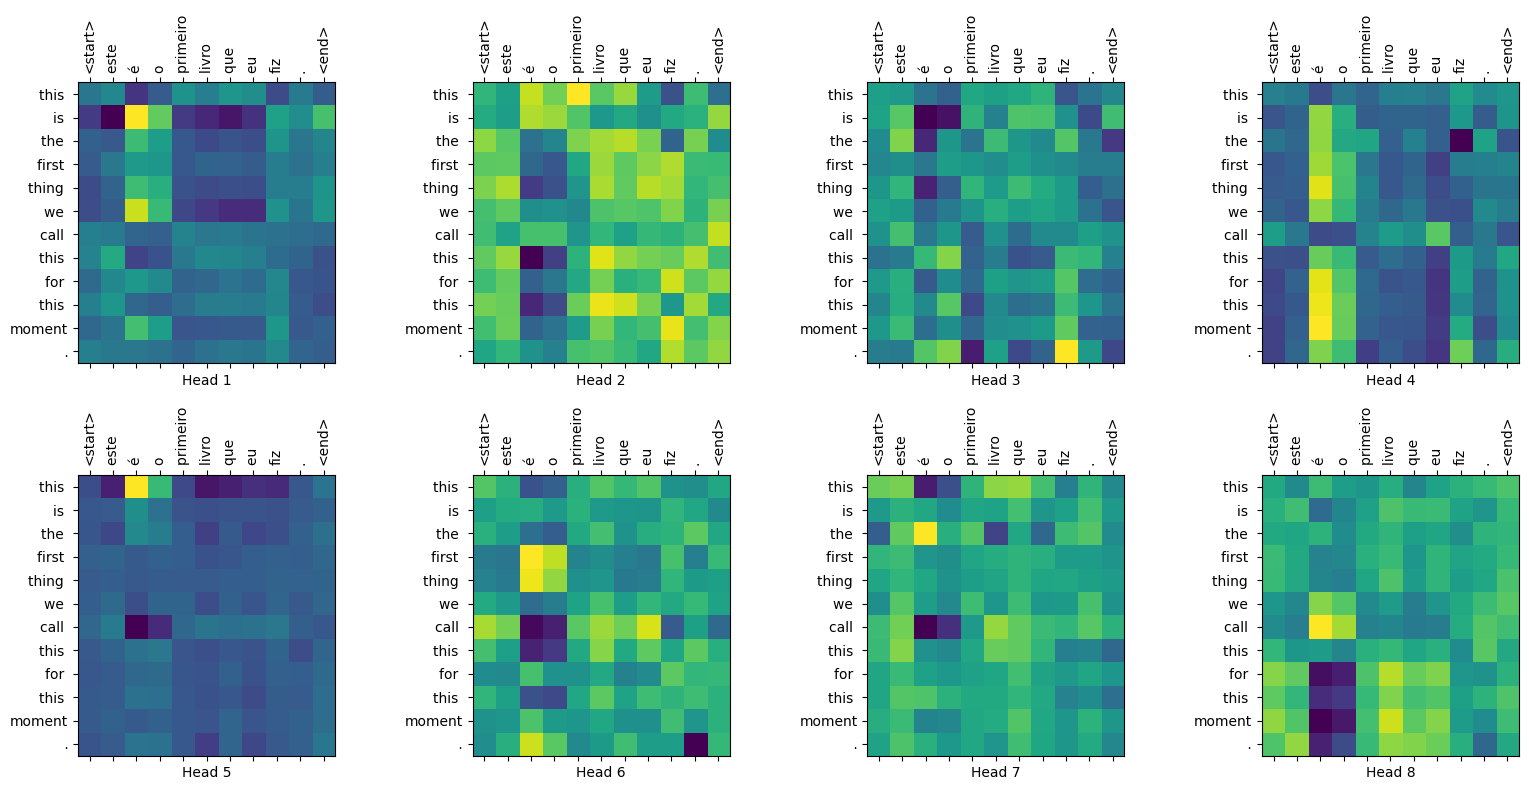

Real translation: this is the first book i've ever done.


In [345]:
translate("este é o primeiro livro que eu fiz.", plot='decoder_layer4_block2')
print ("Real translation: this is the first book i've ever done.")

In [346]:
print("当前 epoch:", epoch)
print("当前 batch:", batch)

当前 epoch: 1
当前 batch: 1053


## Conclusion

You've come to the end of the graded portion of the assignment. By now, you've:

* Create positional encodings to capture sequential relationships in data
* Calculate scaled dot-product self-attention with word embeddings
* Implement masked multi-head attention
* Build and train a Transformer model


Try using a different dataset to train the transformer. You can also create the base transformer or transformer XL by changing the hyperparameters above. You can also use the layers defined here to create [BERT](https://arxiv.org/abs/1810.04805) and train state of the art models. Futhermore, you can implement beam search to get better predictions.



<font color='blue'>
    <b>What you should remember</b>:

- The combination of self-attention and convolutional network layers allows of parallization of training and *faster training*.
- Self-attention is calculated using the generated query Q, key K, and value V matrices.
- Adding positional encoding to word embeddings is an effective way of include sequence information in self-attention calculations.
- Multi-head attention can help detect multiple features in your sentence.
- Masking stops the model from 'looking ahead' during training, or weighting zeroes too much when processing cropped sentences.



# Congratulations on building the first Transformer!!!!!! 🎉

It is not that hard, is it?

<a name='7'></a>
## 7 - References

The Transformer algorithm was due to Vaswani et al. (2017).

- Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin (2017). [Attention Is All You Need](https://arxiv.org/abs/1706.03762)